In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
import os
cur_dir = os.getcwd()
print(cur_dir)

E:\python\2024.12.01\ContraVis_next


In [3]:
raw_data = np.load(r"E:\python\2024.12.01\ContraVis_next\dataset\cifar_resnet_none\features.npy")
labels = np.load(r"E:\python\2024.12.01\ContraVis_next\dataset\cifar_resnet_none\labels.npy")

In [4]:
pattern_type = "stripes"
intensity = 0.2
noisy_data = np.load(rf"E:\python\2024.12.01\ContraVis_next\dataset\cifar_resnet_{pattern_type}_{intensity}\features.npy")
similarity_scores = np.load(rf"E:\python\2024.12.01\ContraVis_next\dataset\cifar_resnet_{pattern_type}_{intensity}\similarity.npy")

In [11]:
class TransformationDataset(torch.utils.data.Dataset):
    def __init__(self,reference_np,target_np,labels):
        self.reference_np = reference_np
        self.target_np = target_np
        self.labels = labels[:,None]
        assert reference_np.shape == target_np.shape,"reference_np and target_np have different shapes"
    def __getitem__(self, index):
        return torch.from_numpy(self.reference_np[index]), torch.from_numpy(self.target_np[index]),torch.from_numpy(self.labels[index])
    def __len__(self):
        return len(self.reference_np)
similarity_threshold = 0.15
mask = similarity_scores > similarity_threshold
transformation_dataset_train = TransformationDataset(raw_data[mask],noisy_data[mask],labels[mask])
transformation_dataset_test = TransformationDataset(raw_data,noisy_data,labels)
transformation_loader_train = torch.utils.data.DataLoader(dataset=transformation_dataset_train,batch_size = 512,shuffle=False)
transformation_loader_test = torch.utils.data.DataLoader(dataset=transformation_dataset_test,batch_size = 512,shuffle=False)

In [19]:
np.sum(mask)

32465

In [6]:
class VisualizationDataset(torch.utils.data.Dataset):
    def __init__(self,dataset_np):
        self.dataset_np = dataset_np
    def __getitem__(self, index):
        return torch.from_numpy(self.dataset_np[index])
    def __len__(self):
        return self.dataset_np.shape[0]
ref_visualization_dataset = VisualizationDataset(raw_data)
ref_visualization_loader = torch.utils.data.DataLoader(dataset=ref_visualization_dataset,batch_size = 64,shuffle=False)
tar_visualization_dataset = VisualizationDataset(noisy_data)
tar_visualization_loader = torch.utils.data.DataLoader(dataset=tar_visualization_dataset,batch_size = 64,shuffle=False)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Train flow matching transformation

In [13]:
from torch.optim.lr_scheduler import StepLR
from models.mlp import TimeMLP
from models.flow_matching import RectifiedFlow
import umap

fm_predictor = TimeMLP(512,[128,64],512,128).to(device)
optimizer_fm = torch.optim.Adam(fm_predictor.parameters(), lr=5e-4)
scheduler = StepLR(optimizer_fm, step_size=15, gamma=0.1)

rf = RectifiedFlow()
reducer = umap.UMAP(n_jobs=-1)
np.random.seed(42)

In [39]:
print(raw_data.shape)

(50000, 512)


In [14]:
vis_ref_umap_res = reducer.fit_transform(raw_data)

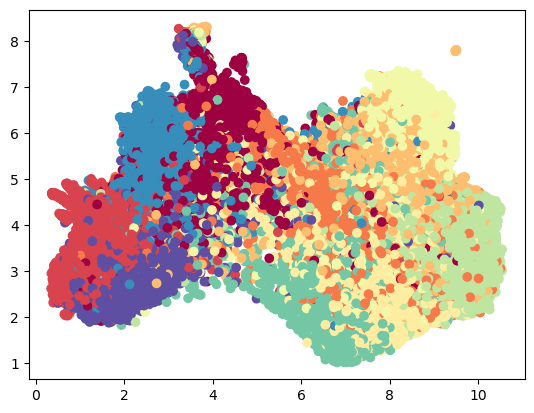

In [15]:
plt.scatter(vis_ref_umap_res[:,0],vis_ref_umap_res[:,1],c=labels,cmap="Spectral")

In [16]:
vis_tar_umap_res = reducer.fit_transform(noisy_data)

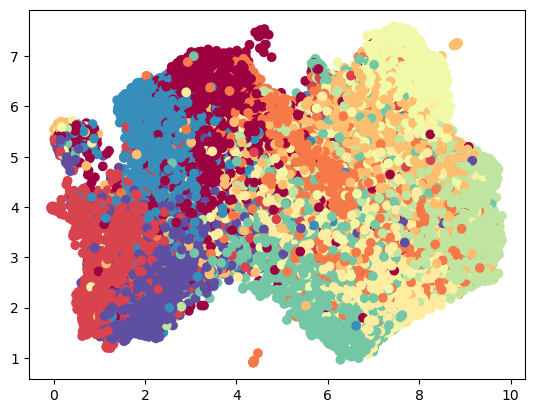

In [17]:
plt.scatter(vis_tar_umap_res[:,0],vis_tar_umap_res[:,1],c=labels,cmap="Spectral")

In [18]:
from models.flow_matching import fm_infer

fm_epochs = 50
fm_save_dir = "model_weights/fm_predictor_mlp"
if not os.path.exists(fm_save_dir):
    os.makedirs(fm_save_dir)
    print(f"dir:{fm_save_dir} created!")
for epoch in range(fm_epochs):
    loss_epoch = 0.0
    for fm_batch in transformation_loader_train:
        ref,tar,_ = fm_batch
        ref = ref.to(device)
        tar = tar.to(device)
        t = torch.randn(ref.shape[0]).to(device)
        x_t = rf.linear_interpolate(x_1=ref,t=t,x_0=tar)
        optimizer_fm.zero_grad()
        v_pred = fm_predictor(x_t,t)
        loss = rf.mse_loss(v_pred,ref,tar)
        loss.backward()
        optimizer_fm.step()
        loss_epoch+=loss.item()
    print(f"fm epoch:{epoch} loss:{loss_epoch}")
    if epoch%5==0 or epoch==fm_epochs-1:
        fm_save_path = os.path.join(fm_save_dir,f"fm_epoch_{epoch}_{loss_epoch:.3f}.pt")
        torch.save(fm_predictor.state_dict(), fm_save_path)
        with torch.no_grad():
            print(f"epoch:{epoch},start eval")
            transformed_tar_all = []
            for fm_test_batch in transformation_loader_test:
                _,tar_test,_ = fm_test_batch
                tar_test = tar_test.to(device)
                x_ref_pred = fm_infer(fm_predictor,tar_test)
                transformed_tar_all.append(x_ref_pred.detach().cpu().numpy())
            transformed_tar_all_np = np.concatenate(transformed_tar_all)
            print(f"epoch:{epoch}:transformed ready,start umap")
            transformed_umap_res = reducer.fit_transform(transformed_tar_all_np)
            fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (16,8))
            reduced_embeddings = [vis_ref_umap_res,transformed_umap_res]
            fig.suptitle(f"fm_{epoch}_loss_{loss_epoch:.3f}")
            for i,ax in enumerate(axs):
                ax.scatter(reduced_embeddings[i][:,0],reduced_embeddings[i][:,1],c=labels,cmap="Spectral")
                ax.set_title(f"transformed"  if i!=0 else "origin")
            plt.savefig(os.path.join(fm_save_dir,f"ref_epoch{epoch}.png"))
            plt.close()
    scheduler.step()

dir:model_weights/fm_predictor_mlp created!
fm epoch:0 loss:5.873815797269344
epoch:0,start eval
epoch:0:transformed ready,start umap
fm epoch:1 loss:5.703157886862755
fm epoch:2 loss:5.619398631155491
fm epoch:3 loss:5.5702041909098625
fm epoch:4 loss:5.531201496720314
fm epoch:5 loss:5.491886116564274
epoch:5,start eval
epoch:5:transformed ready,start umap
fm epoch:6 loss:5.456410892307758
fm epoch:7 loss:5.421132862567902
fm epoch:8 loss:5.390305407345295
fm epoch:9 loss:5.364567451179028
fm epoch:10 loss:5.341421149671078
epoch:10,start eval
epoch:10:transformed ready,start umap
fm epoch:11 loss:5.323310285806656
fm epoch:12 loss:5.304619014263153
fm epoch:13 loss:5.289287984371185
fm epoch:14 loss:5.2743329256772995
fm epoch:15 loss:5.252179324626923
epoch:15,start eval
epoch:15:transformed ready,start umap
fm epoch:16 loss:5.24862090498209
fm epoch:17 loss:5.247545972466469
fm epoch:18 loss:5.246438480913639
fm epoch:19 loss:5.24555005133152
fm epoch:20 loss:5.239699959754944
epo